# Text Generation with Amazon Bedrock

> *This notebook should work well with the **`Python 3`** kernel from **`SageMaker Distribution 2.1`** in SageMaker Studio*

## Introduction

In this notebook, you will explore different capabilities of Amazon Bedrock and how to use foundation models for the following use cases:

1. **Text Summarization**: Create concise summaries from longer text passages
2. **Code Generation**: Generate Python and SQL code from natural language descriptions
3. **Entity Extraction**: Extract structured information from unstructured text

You'll see how to use the Boto3 SDK to interact with different foundation models available through Amazon Bedrock such as the Amazon Titan and Claude 3 Sonnet foundation models.

### Prerequisites
- Access to Amazon Bedrock
- Appropriate IAM permissions
- Python 3.x environment

## Setup

⚠️ ⚠️ ⚠️ Before running this notebook, ensure you've run the [Bedrock basics notebook](../00_Prerequisites/bedrock_basics.ipynb#Prerequisites) notebook. ⚠️ ⚠️ ⚠️


In [16]:
import json
import os
import sys

import boto3
import botocore


session = boto3.Session(profile_name='profile-name')

boto3_bedrock = session.client('bedrock-runtime', region_name='us-east-1')

## 1. Text Summarization: Create concise summaries from longer text passages
 
To learn detail of API request to Amazon Bedrock, this notebook introduces how to create API request and send the request via Boto3 rather than relying on langchain, which gives simpler API by wrapping Boto3 operation. 

### Request Syntax of InvokeModel in Boto3


We use `InvokeModel` API for sending request to a foundation model. Here is an example of API request for sending text to Amazon Titan Text Large. Inference parameters in `textGenerationConfig` depends on the model that you are about to use. Inference paramerters of Amazon Titan Text are:
- **maxTokenCount** configures the max number of tokens to use in the generated response. (int, defaults to 512)
- **stopSequences** is used to make the model stop at a desired point, such as the end of a sentence or a list. The returned response will not contain the stop sequence.
- **temperature** modulates the probability density function for the next tokens, implementing the temperature sampling technique. This parameter can be used to deepen or flatten the density function curve. A lower value results in a steeper curve and more deterministic responses, whereas a higher value results in a flatter curve and more random responses. (float, defaults to 0, max value is 1.5)
- **topP** controls token choices, based on the probability of the potential choices. If you set Top P below 1.0, the model considers only the most probable options and ignores less probable options. The result is more stable and repetitive completions.

```python
response = bedrock.invoke_model(body={
                                   "inputText": "this is where you place your input text",
                                   "textGenerationConfig": {
                                       "maxTokenCount": 4096,
                                       "stopSequences": [],
                                       "temperature":0,
                                       "topP":1
                                       },
                                },
                                modelId="amazon.titan-tg1-large", 
                                accept=accept, 
                                contentType=contentType)

```

### Writing prompt with text to be summarized

In this notebook, you can use any short text whose tokens are less than the maximum token of a foundation model. As an exmple of short text, let's take one paragraph of an [AWS blog post](https://aws.amazon.com/jp/blogs/machine-learning/announcing-new-tools-for-building-with-generative-ai-on-aws/) about announcement of Amazon Bedrock.

The prompt starts with an instruction `Please provide a summary of the following text.`, and includes text surrounded by  `<text>` tag. 

In [17]:
prompt = """
Please provide a summary of the following text. Do not add any information that is not mentioned in the text below.

<text>
AWS took all of that feedback from customers, and today we are excited to announce Amazon Bedrock, \
a new service that makes FMs from AI21 Labs, Anthropic, Stability AI, and Amazon accessible via an API. \
Bedrock is the easiest way for customers to build and scale generative AI-based applications using FMs, \
democratizing access for all builders. Bedrock will offer the ability to access a range of powerful FMs \
for text and images—including Amazons Titan FMs, which consist of two new LLMs we’re also announcing \
today—through a scalable, reliable, and secure AWS managed service. With Bedrock’s serverless experience, \
customers can easily find the right model for what they’re trying to get done, get started quickly, privately \
customize FMs with their own data, and easily integrate and deploy them into their applications using the AWS \
tools and capabilities they are familiar with, without having to manage any infrastructure (including integrations \
with Amazon SageMaker ML features like Experiments to test different models and Pipelines to manage their FMs at scale).
</text>

"""

## Creating request body with prompt and inference parameters 

Following the request syntax of `invoke_model`, you create request body with the above prompt and inference parameters.

### Titan:

In [18]:
body = json.dumps({"inputText": prompt, 
                   "textGenerationConfig":{
                       "maxTokenCount":1024,
                       "stopSequences":[],
                       "temperature":0,
                       "topP":1
                   },
                  }) 


## Invoke foundation model via Boto3

Here sends the API request to Amazon Bedrock with specifying request parameters `modelId`, `accept`, and `contentType`. Following the prompt, the foundation model in Amazon Bedrock sumamrizes the text.

In [19]:
# modelId = 'amazon.titan-text-premier-v1:0' # Make sure Titan text premier is available in the account you are doing this workhsop in before uncommenting!
modelId = "amazon.titan-tg1-large"
accept = 'application/json'
contentType = 'application/json'

try:
    
    response = boto3_bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())

    print(response_body.get('results')[0].get('outputText'))

except botocore.exceptions.ClientError as error:
    
    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")
        
    else:
        raise error

Amazon Bedrock is a new service that makes FMs from AI21 Labs, Anthropic, Stability AI, and Amazon accessible via an API. It offers a scalable, reliable, and secure AWS managed service with serverless experience, allowing customers to easily find the right model, get started quickly, privately customize FMs with their own data, and easily integrate and deploy them into their applications.


In the above the TTP generates the entire summary for the given prompt in a single output. Note that this can be slow if the output contains large amount of tokens. 

### Claude 3 Sonnet:

In [20]:
body = json.dumps({
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 4096,
    "temperature": 0.5,
    "top_k":250,
    "top_p":0.5,
    "messages": [
        {
            "role": "user",
            "content": [{"type": "text", "text": prompt}]
        }
    ],
})

In [21]:
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = 'application/json'
contentType = 'application/json'

response = boto3_bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())
print(response_body["content"][0]["text"])

Here is a summary of the provided text:

AWS announced a new service called Amazon Bedrock that provides access to foundation models (FMs) from AI companies like AI21 Labs, Anthropic, Stability AI, and Amazon itself via an API. Bedrock aims to democratize access to powerful generative AI models for text and images, including Amazon's own new Titan large language models announced today. Bedrock offers a serverless experience allowing customers to easily find the right model, get started quickly, privately customize models with their own data, and integrate/deploy the models into applications using familiar AWS tools and capabilities without managing infrastructure. Key features include integration with Amazon SageMaker for model testing (Experiments) and management at scale (Pipelines).


### Conclusion on use case - 1. Text Summarization
You have now experimented with using `boto3` SDK which provides a vanilla exposure to Amazon Bedrock API. Using this API you have seen the use case of generating a summary of AWS news about Amazon Bedrock.

### Take aways
- Adapt this notebook to experiment with different models available through Amazon Bedrock such as Anthropic Claude and AI21 Labs Jurassic models.
- Change the prompts to your specific usecase and evaluate the output of different models.
- Play with the token length to understand the latency and responsiveness of the service.
- Apply different prompt engineering principles to get better outputs.

# 2. Code Generation: Generate Python and SQL code from natural language descriptions
## Introduction

In this notebook we show you how to use a LLM to generate code based on the text prompt. We will use Bedrock's Claude 3 Sonnet  using the Boto3 API. 

The prompt used in this example is called a zero-shot prompt because we are not providing any examples of text other than the prompt.

**Note:** *This notebook can be run within or outside of AWS environment.*

#### Context
To demonstrate the code generation capability of Amazon Bedrock, we will explore the use of Boto3 client to communicate with Amazon Bedrock API. We will demonstrate different configurations available as well as how simple input can lead to desired outputs. We will explore code generation for two use cases:
1. Python code generation for analytical QnA
2. SQL query generation

#### Pattern
In both use cases, we will simply provide the Amazon Bedrock API with an input consisting of a task, an instruction and an input for the model under the hood to generate an output without providing any additional example. The purpose here is to demonstrate how the powerful LLMs easily understand the task at hand and generate compelling outputs.

![](../imgs/bedrock-code-gen.png)

## Use case 1 - Python code generation for Analytical QnA
To demonstrate the generation capability of models in Amazon Bedrock, let's take the use case of code generation with Python to do some basic analytical QnA.

#### Persona

You are Moe, a Data Analyst, at AnyCompany. The company wants to understand its sales performance for different products for different products over the past year. You have been provided a dataset named sales.csv. The dataset contains the following columns:

- Date (YYYY-MM-DD) format
- Product_ID (unique identifer for each product)
- Price (price at which each product was sold)

#### Implementation
To fulfill this use case, in this notebook we will show how to generate code for a given prompt. We will use the Anthropic Claude 3 using the Amazon Bedrock API with Boto3 client. 


## Code Generation

Following on the use case explained above, let's prepare an input for  the Amazon Bedrock service to generate python program for our use-case.

#### Lab setup - create sample sales.csv data for this lab.

In [22]:
# create sales.csv file
import csv

data = [
    ["date", "product_id", "price", "units_sold"],
    ["2023-01-01", "P001", 50, 20],
    ["2023-01-02", "P002", 60, 15],
    ["2023-01-03", "P001", 50, 18],
    ["2023-01-04", "P003", 70, 30],
    ["2023-01-05", "P001", 50, 25],
    ["2023-01-06", "P002", 60, 22],
    ["2023-01-07", "P003", 70, 24],
    ["2023-01-08", "P001", 50, 28],
    ["2023-01-09", "P002", 60, 17],
    ["2023-01-10", "P003", 70, 29],
    ["2023-02-11", "P001", 50, 23],
    ["2023-02-12", "P002", 60, 19],
    ["2023-02-13", "P001", 50, 21],
    ["2023-02-14", "P003", 70, 31],
    ["2023-03-15", "P001", 50, 26],
    ["2023-03-16", "P002", 60, 20],
    ["2023-03-17", "P003", 70, 33],
    ["2023-04-18", "P001", 50, 27],
    ["2023-04-19", "P002", 60, 18],
    ["2023-04-20", "P003", 70, 32],
    ["2023-04-21", "P001", 50, 22],
    ["2023-04-22", "P002", 60, 16],
    ["2023-04-23", "P003", 70, 34],
    ["2023-05-24", "P001", 50, 24],
    ["2023-05-25", "P002", 60, 21]
]

# Write data to sales.csv
with open('sales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

print("sales.csv has been created!")

sales.csv has been created!


#### Analyzing sales with Amazon Bedrock generated Python program

In [23]:
# Create the prompt
# Analyzing sales

prompt_data = """
You have a CSV, sales.csv, with columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Create a python program to analyze the sales data from a CSV file. The program should be able to read the data, and determine below:

- Total revenue for the year
- The product with the highest revenue
- The date with the highest revenue
- Visualize monthly sales using a bar chart

Ensure the code is syntactically correct, bug-free, optimized, not span multiple lines unnessarily, and prefer to use standard libraries. Return only python code without any surrounding text, explanation or context.
Do not use pandas library for the solution.
"""

Let's use the Anthropic Claude 3 Sonnet model.

In [24]:
body = json.dumps({
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 4096,
    "temperature": 0.1,
    "top_k":250,
    "top_p":0.99,
    "messages": [
        {
            "role": "user",
            "content": [{"type": "text", "text": prompt_data}]
        }
    ],
})

Invoke the Anthropic Claude 3 Sonnet model to generate the code:

In [25]:
from IPython.display import clear_output, display, display_markdown, Markdown
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = 'application/json'
contentType = 'application/json'

response = boto3_bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())

display_markdown(Markdown(print(response_body["content"][0]["text"], end='')))

import csv
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt

def parse_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d').date()

def analyze_sales(file_path):
    total_revenue = 0
    product_revenue = defaultdict(int)
    date_revenue = defaultdict(int)
    monthly_sales = defaultdict(int)

    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            date = parse_date(row['date'])
            product_id = row['product_id']
            price = float(row['price'])
            units_sold = int(row['units_sold'])
            revenue = price * units_sold

            total_revenue += revenue
            product_revenue[product_id] += revenue
            date_revenue[date] += revenue
            monthly_sales[date.month] += revenue

    highest_product_revenue = max(product_revenue.items(), key=lambda x: x[1])
    highest_date_revenue = max(date_revenue.items(), key=lamb

#### (Optional) Execute the Bedrock generated code for validation. Go to text editor to copy the generated code as printed output can be trucncated. Replace the code in below cell.

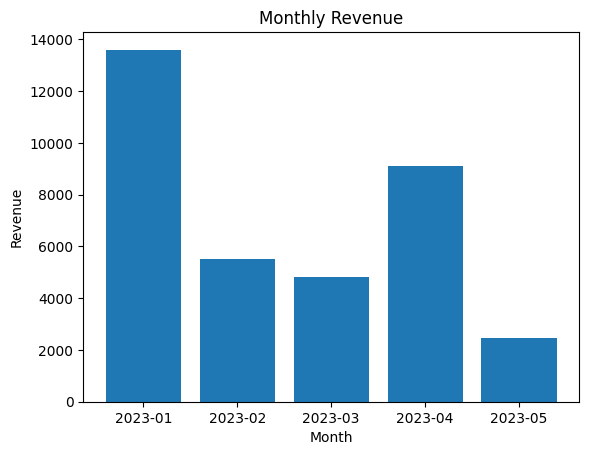

Total Revenue: 35490.0
Product with max revenue: P002
Date with max revenue: 2023-05-25


In [28]:
# Sample Generated Python Code ( Generated with Amazon Bedrock in previous step)

import csv
from collections import defaultdict
import matplotlib.pyplot as plt

revenue = 0
monthly_revenue = defaultdict(int)
product_revenue = defaultdict(int)
max_revenue = 0
max_revenue_date = ''
max_revenue_product = ''

with open('sales.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        date = row[0]
        product = row[1]
        price = float(row[2])
        units = int(row[3])

        revenue += price * units
        product_revenue[product] += price * units
        monthly_revenue[date[:7]] += price * units

        if revenue > max_revenue:
            max_revenue = revenue
            max_revenue_date = date
            max_revenue_product = product

months = list(monthly_revenue.keys())
values = list(monthly_revenue.values())

plt.bar(months, values)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue')
plt.show()

print('Total Revenue:', revenue)
print('Product with max revenue:', max_revenue_product)
print('Date with max revenue:', max_revenue_date)

## Use case 2 - SQL query generation

In this section we show you how to use a LLM to generate SQL queries to analyze Sales data. We will use Bedrock's Claude 3 Sonnet model using the Boto3 API. 

The prompt used in this example is called a zero-shot prompt because we are not providing any examples of text other than the prompt.

#### Pattern
We will simply provide the Amazon Bedrock API with an input consisting of a task, an instruction and an input for the model to generate an output without providing any additional examples. The purpose here is to demonstrate how the powerful LLMs easily understand the task at hand and generate compelling outputs.

#### Use case
Let's take the use case to generate SQL queries to analyze sales data, focusing on top products and average monthly sales.

#### Persona
Maya is a business analyst, at AnyCompany primarily focusing on sales and inventory data. She is transitioning from Speadsheet analysis to data-driven analysis and want to use SQL to fetch specific data points effectively. She wants to use LLMs to generate SQL queries for her analysis. 

#### Implementation
To fulfill this use case, in this notebook we will show how to generate SQL queries. We will use the Anthropic Claude 3 model using the Amazon Bedrock API with Boto3 client. 

### Generate SQL Query

Following on the use case explained above, let's prepare an input for  the Amazon Bedrock service to generate some SQL queries.

In [29]:
# create the prompt to generate SQL query
prompt_data = """
AnyCompany has a database with a table named sales_data containing sales records. The table has following columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Can you generate SQL queries for the below: 
- Identify the top 5 best selling products by total sales for the year 2023
- Calculate the average of total monthly sales for the year 2023
"""

Let's use the Claude 3 Sonnet model: 

In [30]:
body = json.dumps({
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 4096,
    "temperature": 0.1,
    "top_k":250,
    "top_p":0.99,
    "messages": [
        {
            "role": "user",
            "content": [{"type": "text", "text": prompt_data}]
        }
    ],
})

In [31]:
from IPython.display import clear_output, display, display_markdown, Markdown

modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
accept = 'application/json'
contentType = 'application/json'

response = boto3_bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())

display_markdown(Markdown(print(response_body["content"][0]["text"], end='')))


Sure, here are the SQL queries for the given requirements:

1. Identify the top 5 best selling products by total sales for the year 2023:

```sql
SELECT
    product_id,
    SUM(units_sold * price) AS total_sales
FROM
    sales_data
WHERE
    date BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY
    product_id
ORDER BY
    total_sales DESC
LIMIT 5;
```

This query first calculates the total sales for each product by multiplying the units sold with the price and summing it up. It then groups the results by product_id and orders them in descending order of total_sales. Finally, it limits the output to the top 5 rows, giving us the top 5 best-selling products by total sales for the year 2023.

2. Calculate the average of total monthly sales for the year 2023:

```sql
SELECT
    ROUND(AVG(monthly_sales), 2) AS avg_monthly_sales
FROM
    (SELECT
         DATE_FORMAT(date, '%Y-%m') AS month_year,
         SUM(units_sold * price) AS monthly_sales
     FROM
         sales_data
     WHERE
        

## Conclusion on use case 2 - Code Generation
You have now experimented with using `boto3` SDK which provides a vanilla exposure to Amazon Bedrock API. Using this API you generate a python program to analyze and visualize given sales data, and generate SQL statements based on an input task and schema.

### Take aways
- Adapt this notebook to experiment with different models available through Amazon Bedrock such as Amazon Titan and AI21 Labs Jurassic models!


## 3. Entity Extraction: Extract structured information from unstructured text

### Context
Entity extraction is an NLP technique that allows us to automatically extract specific data from naturally written text, such as news, emails, books, etc.
That data can then later be saved to a database, used for lookup or any other type of processing.

Classic entity extraction programs usually limit you to pre-defined classes, such as name, address, price, etc. or require you to provide many examples of types of entities you are interested in.
By using a LLM for entity extraction, in most cases you are only required to specify what you need to extract in natural language. This gives you flexibility and accuracy in your queries, while saving time by removing the need for data labeling.

In addition, LLM entity extraction can be used to help you assemble a dataset to create a customised solution for your use case, such as [Amazon Comprehend custom entity](https://docs.aws.amazon.com/comprehend/latest/dg/custom-entity-recognition.html) recognition.

## Entity Extraction

For this exercise we will pretend to be an online bookstore that receives questions and orders by email.
Our task is to extract relevant information from the email to process the order.

Let's begin by taking a look at the sample email:

In [32]:
from pathlib import Path

emails_dir = Path(".") / "emails"
with open(emails_dir / "00_treasure_island.txt") as f:
    book_question_email = f.read()

print(book_question_email)

Dear Sir or Madam,

I would like to order Treasure Island, do you have it in stock?

Also, is it possible to pay by cheque?

Yours sincerely,
John Smith


### Basic approach

First, let's define a function to process queries using Claude 3. In the below, we use a system prompt to tell the
LLM to act as a bookstore assistant.

In [33]:
def bookstore_assistant(query: str) -> str:
    body = json.dumps({
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 4096,
        "temperature": 0.1,
        "top_k":250,
        "top_p":0.99,
        "system": "You are a helpful assistant that processes orders from a bookstore.",
        "messages": [
            {
                "role": "user",
                "content": [{"type": "text", "text": query}]
            }
        ],
    })
    modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
    accept = 'application/json'
    contentType = 'application/json'

    response = boto3_bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())

    return response_body["content"][0]["text"]

For basic cases we can directly ask the model to return the result. Let's try extracting the name of the book.

In [34]:
query = f"""
Given the email inside triple-backticks, please read it and analyse the contents.
If a name of a book is mentioned, return it, otherwise return nothing.

Email: ```
{book_question_email}
```

"""

In [35]:
result = bookstore_assistant(query)
print(result)

The name of the book mentioned in the email is "Treasure Island".


### Model specific prompts

While basic approach works, to achieve best results we recommend to customise your prompts for the particular model you will be using.
In this example we are using `anthropic.claude-3`, [prompt guide for which can be found here](https://docs.anthropic.com/claude/docs/introduction-to-prompt-design).

Here is the a more optimised prompt for Claude v3.

In [36]:
prompt = """

Given the email provided, please read it and analyse the contents.
If a name of a book is mentioned, return it.
If no name is mentioned, return empty string.
The email will be given between <email></email> XML tags.

<email>
{email}
</email>

Return the name of the book between <book></book> XML tags.

"""
query = prompt.format(email=book_question_email)

In [37]:
result = bookstore_assistant(query)
print(result)

<book>Treasure Island</book>


To extract results easier, we can use a helper function:

In [40]:
from bs4 import BeautifulSoup

def extract_by_tag(response: str, tag: str, extract_all=False) -> str | list[str] | None:
    soup = BeautifulSoup(response)
    results = soup.find_all(tag)
    if not results:
        return
        
    texts = [res.get_text() for res in results]
    if extract_all:
        return texts
    return texts[-1]

In [41]:
extract_by_tag(result, "book")

'Treasure Island'

We can check that our model doesn't return arbitrary results when no appropriate information is given (also know as 'hallucination'), by running our prompt on other emails.

In [42]:
with open(emails_dir / "01_return.txt") as f:
    return_email = f.read()

print(return_email)

I didn't like the last book I ordered and would like to return it.


In [43]:
query = prompt.format(email=return_email)
result = bookstore_assistant(query)
print(result)

<book></book>


Using tags also allows us to extract multiple pieces of information at the same time and makes extraction much easier.
In the following prompt we will extract not just the book name, but any questions, requests and customer name.

In [45]:
prompt = """
Given email provided , please read it and analyse the contents.

Please extract the following information from the email:
- Any questions the customer is asking, return it inside <questions></questions> XML tags.
- The customer full name, return it inside <name></name> XML tags.
- Any book names the customer mentions, return it inside <books></books> XML tags.

If a particular bit of information is not present, return an empty string.
Make sure that each question can be understoon by itself, incorporate context if requred.
Each returned question should be concise, remove extra information if possible.
The email will be given between <email></email> XML tags.

<email>
{email}
</email>

Return each question inside <question></question> XML tags.
Return the name of each book inside <book></book> XML tags.
"""

In [46]:
query = prompt.format(email=book_question_email)
result = bookstore_assistant(query)
print(result)

<questions>
<question>Do you have Treasure Island in stock?</question>
<question>Is it possible to pay by cheque?</question>
</questions>
<name>John Smith</name>
<books>
<book>Treasure Island</book>
</books>


In [47]:
extract_by_tag(result, "question", extract_all=True)

['Do you have Treasure Island in stock?', 'Is it possible to pay by cheque?']

In [48]:
extract_by_tag(result, "name")

'John Smith'

In [49]:
extract_by_tag(result, "book", extract_all=True)

['Treasure Island']

### Conclusion on use case - 3 Entity Extraction

Entity extraction is a powerful technique using which you can extract arbitrary data using plain text descriptions.

This is particularly useful when you need to extract specific data which doesn't have clear structure. In such cases regex and other traditional extraction techniques can be very difficult to implement.

### Take aways
- Adapt this notebook to experiment with different models available through Amazon Bedrock such as Amazon Titan and AI21 Labs Jurassic models.
- Change the prompts to your specific usecase and evaluate the output of different models.
- Apply different prompt engineering principles to get better outputs. Refer to the prompt guide for your chosen model for recommendations, e.g. [here is the prompt guide for Claude](https://docs.anthropic.com/claude/docs/introduction-to-prompt-design).

## Conclusion

In this notebook, we've explored text generation capabilities with Amazon Bedrock for the following use cases:

1. **Text Summarization**: Create concise summaries from longer text passages
2. **Code Generation**: Generate Python and SQL code from natural language descriptions
3. **Entity Extraction**: Extract structured information from unstructured text
